<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/LSTM-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from tqdm.notebook import tqdm

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Load data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)
if response.status_code == 200:
    try:
        # Try to read as newline-delimited JSON
        df = pd.read_json(url, lines=True)
    except ValueError:
        # If that fails, try to read as a list of dictionaries
        data = json.loads(response.text)
        df = pd.DataFrame(data)
else:
    print("Failed to download data, check URL or internet connection.")


In [4]:
print("Data shape:", df.shape)
print("\nSample data:")
print(df.head())


Data shape: (26709, 3)

Sample data:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [6]:
# Data preprocessing
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check class distribution
print("\nClass distribution:")
print(df['is_sarcastic'].value_counts())

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    return text

# Apply preprocessing to headline column
df['headline_processed'] = df['headline'].apply(preprocess_text)



Missing values:
article_link    0
headline        0
is_sarcastic    0
dtype: int64

Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [7]:
# Tokenization and vocabulary building
def build_vocab(texts, max_vocab_size=10000):
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())

    # Add special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}

    # Add most common words
    for word, _ in word_counts.most_common(max_vocab_size - len(vocab)):
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

In [8]:
# Build vocabulary
vocab = build_vocab(df['headline_processed'])
print(f"\nVocabulary size: {len(vocab)}")

# Convert text to sequence of indices
def text_to_sequence(text, vocab, max_length=50):
    words = text.split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words[:max_length]]

    # Pad sequence
    if len(sequence) < max_length:
        sequence = sequence + [vocab['<PAD>']] * (max_length - len(sequence))

    return sequence



Vocabulary size: 10000


In [9]:
# Create sequences
max_length = 50
df['sequence'] = df['headline_processed'].apply(lambda x: text_to_sequence(x, vocab, max_length))

# Convert to numpy arrays
X = np.array(df['sequence'].tolist())
y = np.array(df['is_sarcastic'].tolist())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (21367, 50)
Testing set shape: (5342, 50)


In [10]:
# Create PyTorch dataset
class SarcasmDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


In [11]:
# Create datasets and dataloaders
train_dataset = SarcasmDataset(X_train, y_train)
test_dataset = SarcasmDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [12]:
# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)

        # If bidirectional, we need to multiply hidden_dim by 2
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sequence length]
        embedded = self.embedding(text)
        # embedded = [batch size, sequence length, embedding dim]

        output, (hidden, cell) = self.lstm(embedded)
        # output = [batch size, sequence length, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]

        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        # hidden = [batch size, hidden dim * n directions]
        hidden = self.dropout(hidden)

        return self.fc(hidden)

In [13]:
# Set model hyperparameters
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

In [14]:
# Initialize model
model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)
model = model.to(device)


In [15]:
# Print model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


LSTMClassifier(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 1631041


In [16]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


In [17]:
# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        # Get batch
        text, labels = batch
        text = text.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(text).squeeze(1)

        # Calculate loss
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()

        # Convert predictions to binary
        binary_preds = torch.round(torch.sigmoid(predictions)).cpu().detach().numpy()
        epoch_preds.extend(binary_preds)
        epoch_labels.extend(labels.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(epoch_labels, epoch_preds)
    precision = precision_score(epoch_labels, epoch_preds, zero_division=0)
    recall = recall_score(epoch_labels, epoch_preds, zero_division=0)
    f1 = f1_score(epoch_labels, epoch_preds, zero_division=0)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1


In [18]:
# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []
    epoch_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Get batch
            text, labels = batch
            text = text.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(text).squeeze(1)

            # Calculate loss
            loss = criterion(predictions, labels)

            # Update metrics
            epoch_loss += loss.item()

            # Save predictions and labels
            probs = torch.sigmoid(predictions).cpu().numpy()
            epoch_probs.extend(probs)
            binary_preds = (probs >= 0.5).astype(int)
            epoch_preds.extend(binary_preds)
            epoch_labels.extend(labels.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(epoch_labels, epoch_preds)
    precision = precision_score(epoch_labels, epoch_preds, zero_division=0)
    recall = recall_score(epoch_labels, epoch_preds, zero_division=0)
    f1 = f1_score(epoch_labels, epoch_preds, zero_division=0)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(epoch_labels, epoch_probs)
    roc_auc = auc(fpr, tpr)

    # Calculate confusion matrix
    cm = confusion_matrix(epoch_labels, epoch_preds)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1, fpr, tpr, roc_auc, cm


In [19]:
# Training loop
n_epochs = 10
best_test_acc = 0
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [20]:
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # Train model
    train_loss, train_acc, train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate model
    test_loss, test_acc, test_precision, test_recall, test_f1, fpr, tpr, roc_auc, cm = evaluate(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print("Model saved!")

    # Early stopping if accuracy is already >= 80%
    if train_acc >= 0.8 and test_acc >= 0.8:
        print(f"Early stopping: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")
        break

# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc, test_precision, test_recall, test_f1, fpr, tpr, roc_auc, cm = evaluate(model, test_loader, criterion)

print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Epoch 1/10


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.5043, Train Acc: 0.7416
Train Precision: 0.7151, Train Recall: 0.6834, Train F1: 0.6989
Test Loss: 0.4189, Test Acc: 0.8034
Test Precision: 0.7796, Test Recall: 0.7702, Test F1: 0.7749
ROC AUC: 0.8878
Model saved!

Epoch 2/10


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3570, Train Acc: 0.8402
Train Precision: 0.8137, Train Recall: 0.8248, Train F1: 0.8192
Test Loss: 0.3838, Test Acc: 0.8306
Test Precision: 0.7906, Test Recall: 0.8355, Test F1: 0.8124
ROC AUC: 0.9104
Model saved!
Early stopping: train acc = 0.8402, test acc = 0.8306


Evaluating:   0%|          | 0/84 [00:00<?, ?it/s]


Final Test Results:
Accuracy: 0.8306
Precision: 0.7906
Recall: 0.8355
F1 Score: 0.8124
ROC AUC: 0.9104


In [21]:
# Visualize metrics
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

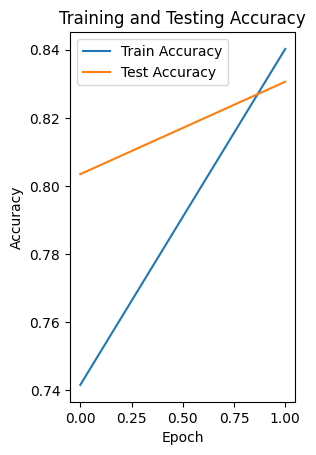

In [22]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

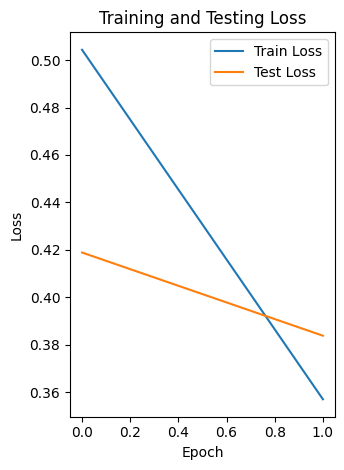

In [24]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png')
plt.show()

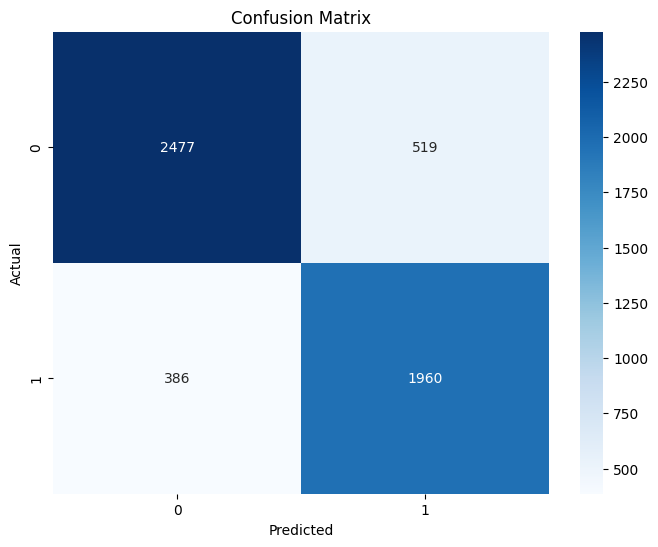

In [25]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

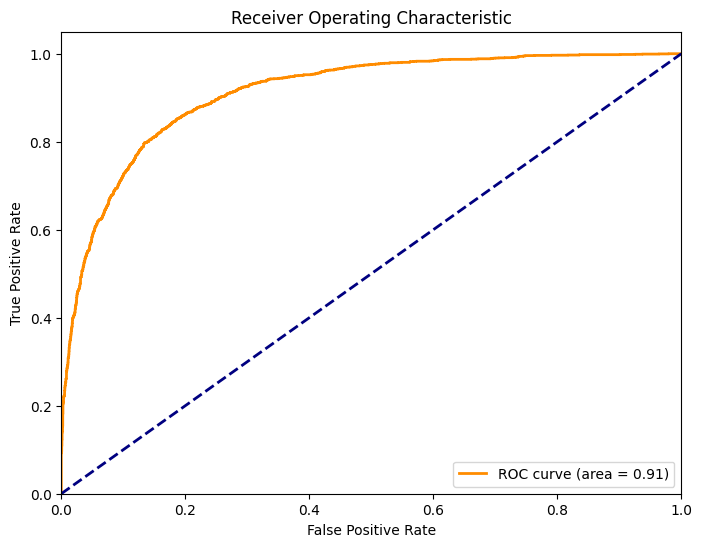

In [26]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()